# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing. 
* canton: swiss canton.
* class_level: school year in swiss system.


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* timestamp: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* session_id: session during which the event took place.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).


### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* validation: used to validate the format of the input.
* solution: solution to question.
* type: type of question that was answered. 


In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = './data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [2]:
# Your code goes here
n = len(pd.unique(users['user_id']))
print("The number of distinct participants in the data set is:", n)

The number of distinct participants in the data set is: 13695


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

In [3]:
# Your code goes here
user_id = transactions['user_id'].value_counts(dropna=False)
df = pd.DataFrame({"User Id": user_id.index, "Count": user_id.tolist(), "Count %": user_id.tolist()/np.sum(user_id.tolist()) })

In [4]:
df

,User Id,Count,Count %
0,396334.0,1723,0.002154
1,394780.0,1491,0.001864
2,394913.0,1372,0.001715
3,401331.0,1338,0.001672
4,394677.0,1262,0.001577
...,...,...,...
10488,393675.0,1,0.000001
10489,403199.0,1,0.000001
10490,404161.0,1,0.000001
10491,404418.0,1,0.000001


In [5]:
import seaborn as sns

[Text(0.5, 0, 'User Id'), Text(0, 0.5, 'Count')]

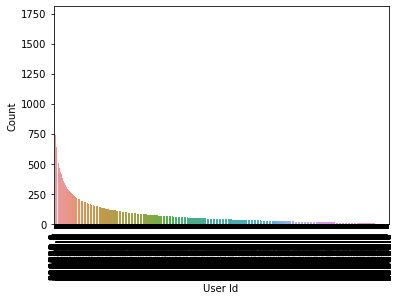

In [6]:
ax = sns.countplot(data=transactions, x='user_id', order = transactions['user_id'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='User Id', ylabel='Count')

<AxesSubplot:title={'center':'Histogram of Transactions'}, ylabel='Frequency'>

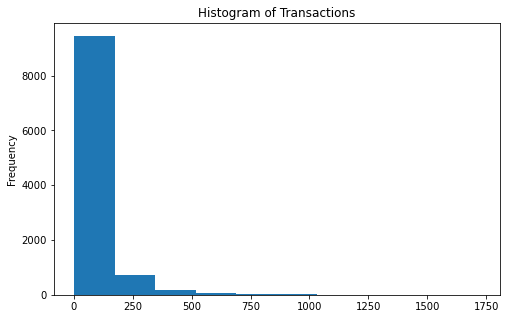

In [7]:
user_id.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Transactions"
)

The first plot shows the number of transactions done per user. Nevertheless, I find more appropiate the second plot, where we can see an histogram showing the number of students that are within a range of transactions. The result was as expected: the number of users decreases as the number of transactions increases. In other words, there are only a few users that have done many transactions while the majority are in the first bin.

#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

In [8]:
# Your code goes here
action = events['action'].value_counts(dropna=False).head(10)
df = pd.DataFrame({"Action": action.index, "Count": action.tolist(), "Count %": action.tolist()/np.sum(action.tolist()) })

In [9]:
df

,Action,Count,Count %
0,PAGE_VISIT,653725,0.219579
1,REVIEW_TASK,513389,0.172442
2,SUBMIT_ANSWER,419862,0.141027
3,NAVIGATE_DASHBOARD,350821,0.117837
4,NEXT,277020,0.093048
5,WINDOW_VISIBLE_FALSE,240660,0.080835
6,WINDOW_VISIBLE_TRUE,199287,0.066938
7,VIEW_QUESTION,154592,0.051926
8,OPEN_FEEDBACK,87071,0.029246
9,GO_TO_THEORY,80746,0.027122


[Text(0.5, 0, 'Action'), Text(0, 0.5, 'Count')]

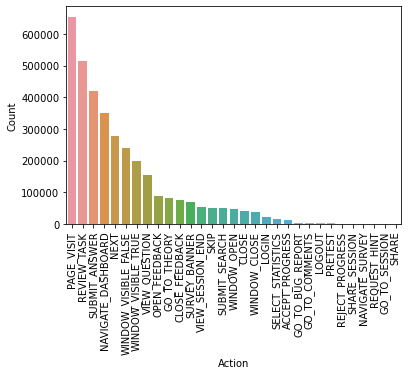

In [10]:
bx = sns.countplot(data=events, x='action', order = events['action'].value_counts().index)
bx.tick_params(axis='x', rotation=90)
bx.set(xlabel='Action', ylabel='Count')

By taking a look at the countplot I have just made before, one can deduce that `PAGE_VISIT` is the most popular action between the users.

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

First of all, I am going to remove the users of the events table that are not in the transactions table with the code provided by the teachers:

In [11]:
# Your code for building the data frame here
def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions
events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


Now, I will create a new dataframe with the users identifiers `user_id` and the total number of events per user `num_events`:

In [12]:
user_events = events['user_id'].value_counts(dropna=False)
data  = pd.DataFrame({"user_id": user_events.index, "num_events": user_events.tolist()})
data.head()

,user_id,num_events
0,393686,10044
1,396334,8965
2,387763,7193
3,394987,6580
4,390316,6524


To continue, I will merge the `events` dataframe with the `data` dataframe:

In [13]:
new_data = events.merge(data, on = 'user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events
0,69,392476,1621584325174,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5
1,70,392476,1621584365975,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5
2,72,392476,1621584441478,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5
3,73,392476,1621584446771,TASK,GO_TO_THEORY,CLICK,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5
4,54076,392476,1625054796765,GENERAL,LOGIN,CLICK,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...
3259194,3516476,389181,1645514034678,DASHBOARD,NAVIGATE_DASHBOARD,VIEW,NaN,NaN,"{""dashboard"": {""title"": ""Mathematik"", ""topics""...",71
3259195,3516528,389181,1645514507946,USER_SESSION,WINDOW_VISIBLE_FALSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71
3259196,3516529,389181,1645514507951,USER_SESSION,WINDOW_VISIBLE_TRUE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71
3259197,3516530,389181,1645514523129,USER_SESSION,WINDOW_VISIBLE_FALSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71


In [14]:
users.head()

,user_id,gender,canton,class_level
0,387604,NaN,NaN,NaN
1,387605,NaN,NaN,NaN
2,387608,NaN,NaN,NaN
3,387615,MALE,SG,Gymnasium - 3. Jahr
4,387643,NaN,NaN,NaN


Now I add the `gender` column to our dataframe by merging our new dataframe called `new_data` with a new data frame consisting in the first two columns of the data frame `users`:

In [15]:
new_data = new_data.merge(users[['user_id', 'gender']], on = 'user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender
0,69,392476,1621584325174,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN
1,70,392476,1621584365975,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN
2,72,392476,1621584441478,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN
3,73,392476,1621584446771,TASK,GO_TO_THEORY,CLICK,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN
4,54076,392476,1625054796765,GENERAL,LOGIN,CLICK,NaN,NaN,NaN,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3259194,3516476,389181,1645514034678,DASHBOARD,NAVIGATE_DASHBOARD,VIEW,NaN,NaN,"{""dashboard"": {""title"": ""Mathematik"", ""topics""...",71,MALE
3259195,3516528,389181,1645514507946,USER_SESSION,WINDOW_VISIBLE_FALSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71,MALE
3259196,3516529,389181,1645514507951,USER_SESSION,WINDOW_VISIBLE_TRUE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71,MALE
3259197,3516530,389181,1645514523129,USER_SESSION,WINDOW_VISIBLE_FALSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/dashboar...",71,MALE


I will now create the `num_reading` column of my data frame `new_data`:

In [16]:
test_data = new_data
test_data = test_data.groupby(['user_id', 'action']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == 'GO_TO_THEORY']
test_data = test_data.rename(columns = {0: "num_reading"}, errors="raise")
test_data = test_data.drop(columns = ['action'])
test_data

,user_id,num_reading
4,387604,368
29,387605,33
54,387608,23
78,387615,10
103,387644,99
...,...,...
130114,404589,4
130151,404597,8
130163,404598,15
130178,404599,38


In [17]:
new_data = new_data.merge(test_data, on='user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading
0,69,392476,1621584325174,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN,1
1,70,392476,1621584365975,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN,1
2,72,392476,1621584441478,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN,1
3,73,392476,1621584446771,TASK,GO_TO_THEORY,CLICK,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,5,NaN,1
4,54076,392476,1625054796765,GENERAL,LOGIN,CLICK,NaN,NaN,NaN,5,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2485012,3513433,404623,1645472829532,USER_SESSION,PAGE_VISIT,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/theory/1...",37,MALE,5
2485013,3513434,404623,1645472829758,THEORY,GO_TO_THEORY,VIEW,NaN,NaN,"{""topicId"": 1063, ""trackingDataType"": ""THEORY_...",37,MALE,5
2485014,3513435,404623,1645472850026,USER_SESSION,WINDOW_VISIBLE_FALSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/theory/1...",37,MALE,5
2485015,3513471,404623,1645473290240,USER_SESSION,WINDOW_VISIBLE_TRUE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/theory/1...",37,MALE,5


I will proceed in a similar way to the creation of the `num_reading` column to introduce the `num_questions` column in the data frame `new_data`:

In [18]:
test_data = new_data
test_data = test_data.groupby(['user_id', 'action']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == 'SUBMIT_ANSWER']
test_data = test_data.rename(columns = {0: "num_questions"}, errors="raise")
test_data = test_data.drop(columns = ['action'])
test_data

,user_id,num_questions
14,387604,97
40,387605,217
65,387608,54
87,387615,15
109,387644,30
...,...,...
77189,404573,27
77201,404589,9
77213,404597,1
77227,404598,1


In [19]:
new_data = new_data.merge(test_data, on='user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading,num_questions
0,228,388047,1621592142012,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81
1,231,388047,1621592157187,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81
2,298477,388047,1630908913706,GENERAL,LOGIN,CLICK,NaN,NaN,NaN,738,MALE,2,81
3,298478,388047,1630908913829,USER_SESSION,PAGE_VISIT,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/privacy/...",738,MALE,2,81
4,298483,388047,1630908915518,USER_SESSION,PAGE_VISIT,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/privacy/...",738,MALE,2,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2467311,3506638,404597,1645444655985,USER_SESSION,WINDOW_CLOSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/home"", ""...",95,NaN,8,1
2467312,3506663,404597,1645444727562,USER_SESSION,WINDOW_OPEN,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/login"", ...",95,NaN,8,1
2467313,3506664,404597,1645444728326,USER_SESSION,PAGE_VISIT,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/home"", ""...",95,NaN,8,1
2467314,3506679,404597,1645444755766,USER_SESSION,WINDOW_CLOSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/home"", ""...",95,NaN,8,1


Finally, I just need to compute the number of correct answers/total number of answers for every user (`percentage_correct`) and add that information to my dataframe (`new_data`).

In [20]:
transactions.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type
0,1061991,cf99b0d7-279a-4ae0-8ef3-a15514e350b6,387604.0,111K3PY6sbr8ac1mRGpse1,87668,NaN,NaN,1637146446763,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,NaN
1,1066631,13e3086b-1c4e-4d28-87a3-0582ccf495c6,387604.0,111K3PY6sbr8ac1mRGpse1,87668,NaN,NaN,1637233737283,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,NaN
2,1011975,6f292166-86bd-4ec9-81e8-22e9033d571e,387604.0,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1636444658255,1.636445e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE
3,1020790,79a7d731-a36b-4529-a11b-108b9f877a04,387604.0,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1636561847705,1.636562e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE
4,1061970,a45b6464-371e-47f4-842c-34f9e345b4ec,387604.0,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1637146373965,1.637146e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE


In [21]:
new_transactions = transactions[['transaction_token', 'evaluation']]
new_transactions

,transaction_token,evaluation
0,cf99b0d7-279a-4ae0-8ef3-a15514e350b6,NaN
1,13e3086b-1c4e-4d28-87a3-0582ccf495c6,NaN
2,6f292166-86bd-4ec9-81e8-22e9033d571e,CORRECT
3,79a7d731-a36b-4529-a11b-108b9f877a04,CORRECT
4,a45b6464-371e-47f4-842c-34f9e345b4ec,CORRECT
...,...,...
800013,06d45030-3e4b-478a-ac7b-8ea1baaa72e5,NaN
800014,cf5959df-cf20-459b-82f4-ebaea1c5d06b,NaN
800015,7c9956b4-d2e2-4f30-9245-8155d6636bd5,NaN
800016,7e328437-52df-4697-94e9-186844c3e269,PARTIAL


In [22]:
dictionary = {
  "CORRECT": 1,
  "PARTIAL": 0.5,
  "WRONG": 0
}
new_transactions_data = new_transactions['evaluation'].map(dictionary)
new_transactions_data

0         NaN
1         NaN
2         1.0
3         1.0
4         1.0
         ... 
800013    NaN
800014    NaN
800015    NaN
800016    0.5
800017    0.5
Name: evaluation, Length: 800018, dtype: float64

In [23]:
new_transactions_data = pd.DataFrame(new_transactions_data)
new_transactions_data['transaction_token'] = new_transactions['transaction_token']
new_transactions_data

,evaluation,transaction_token
0,NaN,cf99b0d7-279a-4ae0-8ef3-a15514e350b6
1,NaN,13e3086b-1c4e-4d28-87a3-0582ccf495c6
2,1.0,6f292166-86bd-4ec9-81e8-22e9033d571e
3,1.0,79a7d731-a36b-4529-a11b-108b9f877a04
4,1.0,a45b6464-371e-47f4-842c-34f9e345b4ec
...,...,...
800013,NaN,06d45030-3e4b-478a-ac7b-8ea1baaa72e5
800014,NaN,cf5959df-cf20-459b-82f4-ebaea1c5d06b
800015,NaN,7c9956b4-d2e2-4f30-9245-8155d6636bd5
800016,0.5,7e328437-52df-4697-94e9-186844c3e269


In [24]:
new_data = new_data.merge(new_transactions_data, on='transaction_token')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading,num_questions,evaluation
0,228,388047,1621592142012,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN
1,231,388047,1621592157187,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN
2,298538,388047,1630908932575,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN
3,298558,388047,1630908937402,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN
4,298571,388047,1630908939705,SESSION,CLOSE,CLICK,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125994,3505992,404597,1645443422671,SESSION,CLOSE,CLICK,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN
1125995,3506510,404597,1645444477444,SESSION,REVIEW_TASK,VIEW,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN
1125996,3506069,404597,1645443518003,SESSION,REVIEW_TASK,VIEW,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5
1125997,3506097,404597,1645443571550,TASK,SUBMIT_ANSWER,CLICK,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5


In [25]:
test_data = new_data[['user_id', 'evaluation']]
test_data = test_data.groupby(['user_id', 'evaluation']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0: 'counts'})
test_data['total_points'] = test_data['evaluation'] * test_data['counts']
test_data = test_data[['user_id', 'total_points']]
test_data = test_data.groupby('user_id').aggregate(lambda x: np.sum(np.array(list(x)))).reset_index()
test_data

,user_id,total_points
0,387604,147.0
1,387605,315.5
2,387608,114.0
3,387615,43.0
4,387644,73.0
...,...,...
4227,404573,38.5
4228,404589,16.5
4229,404597,1.0
4230,404598,3.0


In [26]:
new_data = new_data.merge(test_data, on='user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading,num_questions,evaluation,total_points
0,228,388047,1621592142012,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0
1,231,388047,1621592157187,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0
2,298538,388047,1630908932575,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0
3,298558,388047,1630908937402,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0
4,298571,388047,1630908939705,SESSION,CLOSE,CLICK,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125994,3505992,404597,1645443422671,SESSION,CLOSE,CLICK,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0
1125995,3506510,404597,1645444477444,SESSION,REVIEW_TASK,VIEW,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0
1125996,3506069,404597,1645443518003,SESSION,REVIEW_TASK,VIEW,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0
1125997,3506097,404597,1645443571550,TASK,SUBMIT_ANSWER,CLICK,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0


In [27]:
test_data = new_data[['user_id', 'evaluation']]
test_data = test_data.groupby(['user_id']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0: 'counts'})
test_data

,user_id,counts
0,387604,469
1,387605,900
2,387608,225
3,387615,79
4,387644,127
...,...,...
4227,404573,123
4228,404589,31
4229,404597,9
4230,404598,8


In [28]:
new_data = new_data.merge(test_data, on='user_id')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading,num_questions,evaluation,total_points,counts
0,228,388047,1621592142012,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0,313
1,231,388047,1621592157187,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0,313
2,298538,388047,1630908932575,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313
3,298558,388047,1630908937402,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313
4,298571,388047,1630908939705,SESSION,CLOSE,CLICK,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125994,3505992,404597,1645443422671,SESSION,CLOSE,CLICK,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0,9
1125995,3506510,404597,1645444477444,SESSION,REVIEW_TASK,VIEW,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0,9
1125996,3506069,404597,1645443518003,SESSION,REVIEW_TASK,VIEW,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0,9
1125997,3506097,404597,1645443571550,TASK,SUBMIT_ANSWER,CLICK,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0,9


In [29]:
new_data['percentage_correct'] = new_data['total_points']/new_data['counts'] * 100
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,num_events,gender,num_reading,num_questions,evaluation,total_points,counts,percentage_correct
0,228,388047,1621592142012,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0,313,44.089457
1,231,388047,1621592157187,TASK,VIEW_QUESTION,VIEW,5b826ed7-2fdd-435c-ab8f-ba45b1b6f94c,30676.0,NaN,738,MALE,2,81,NaN,138.0,313,44.089457
2,298538,388047,1630908932575,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313,44.089457
3,298558,388047,1630908937402,SESSION,REVIEW_TASK,VIEW,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313,44.089457
4,298571,388047,1630908939705,SESSION,CLOSE,CLICK,d580c9e5-448b-4c9c-80b1-eade5394c7ee,9334.0,NaN,738,MALE,2,81,NaN,138.0,313,44.089457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125994,3505992,404597,1645443422671,SESSION,CLOSE,CLICK,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0,9,11.111111
1125995,3506510,404597,1645444477444,SESSION,REVIEW_TASK,VIEW,770dab85-426e-4884-8d73-8e343f983da2,111985.0,NaN,95,NaN,8,1,NaN,1.0,9,11.111111
1125996,3506069,404597,1645443518003,SESSION,REVIEW_TASK,VIEW,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0,9,11.111111
1125997,3506097,404597,1645443571550,TASK,SUBMIT_ANSWER,CLICK,7d9c3bde-ec15-427b-8681-5de9871c2d86,NaN,NaN,95,NaN,8,1,0.5,1.0,9,11.111111


Here is the final dataframe I have obtained:

In [30]:
df_1 = new_data[['user_id', 'gender', 'num_events', 'num_questions', 'percentage_correct', 'num_reading']].drop_duplicates().reset_index()
df_1

,index,user_id,gender,num_events,num_questions,percentage_correct,num_reading
0,0,388047,MALE,738,81,44.089457,2
1,313,388363,NaN,1185,122,50.892857,24
2,761,393224,FEMALE,201,54,69.714286,1
3,936,393232,FEMALE,157,38,63.492063,6
4,1062,393230,NaN,111,33,67.961165,1
...,...,...,...,...,...,...,...
4227,1125818,404573,MALE,232,27,31.300813,1
4228,1125941,404589,MALE,71,9,53.225806,4
4229,1125972,404598,MALE,225,1,37.500000,15
4230,1125980,404599,NaN,169,1,30.000000,38


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [31]:
# Your code for univariate analysis here

# Univariate analysis for numerical features (using the structure provided in the theory lesson)
from scipy import stats
pd.set_option('precision', 2)
feature_list = [df_1['num_events'], df_1['num_questions'], df_1['percentage_correct'],
       df_1['num_reading']]

data = {'Mean': np.mean(feature_list,1),
        'Median':np.median(feature_list,1),
        'Mode': (stats.mode(feature_list,axis=1)[0])[:,0],
        'Variance':np.var(feature_list,1),
        'Std':np.std(feature_list,1),
        'Minimum': np.min(feature_list,1),
        '25%': np.percentile(feature_list, 25, axis=1),
        '75%': np.percentile(feature_list, 75, axis=1),
        'Maximum': np.max(feature_list,1)}
desc_stats_df = pd.DataFrame(data, index =['num_events', 'num_questions', 'percentage_correct',
       'num_reading'])

display(desc_stats_df)

,Mean,Median,Mode,Variance,Std,Minimum,25%,75%,Maximum
num_events,583.01,330.00,155.0,631718.09,794.81,14.0,172.00,647.00,10044.0
num_questions,68.39,33.00,1.0,11231.72,105.98,1.0,15.00,76.00,1054.0
percentage_correct,45.79,46.96,50.0,249.01,15.78,0.0,36.53,56.35,100.0
num_reading,18.29,6.00,2.0,3101.05,55.69,1.0,2.00,15.00,2404.0


In [32]:
# Visual inspection normality (using the code provided in the theory lesson)
def test_normality(data):
    k2, p = stats.normaltest(data)
    alpha = 0.01
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

p = 0
The null hypothesis can be rejected


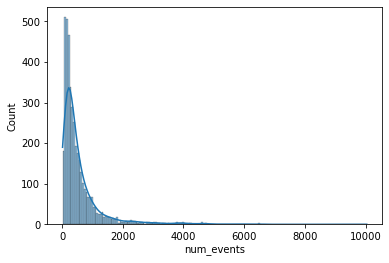

p = 0
The null hypothesis can be rejected


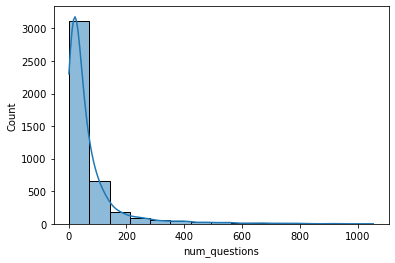

p = 2.0771e-20
The null hypothesis can be rejected


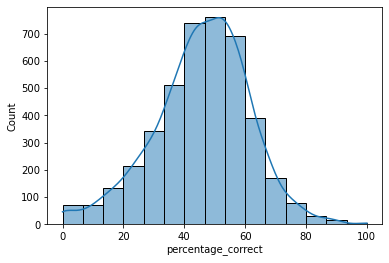

p = 0
The null hypothesis can be rejected


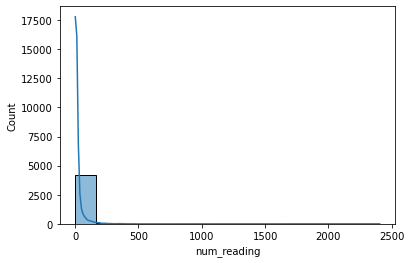

In [33]:
# right skewed
test_normality(df_1['num_events'])
sns.histplot(data=df_1, x = 'num_events', kde=True) 
plt.show()


# right skewed
test_normality(df_1['num_questions'])
sns.histplot(data=df_1, x = 'num_questions', kde=True, bins=15) 
plt.show()


# left skewed
test_normality(df_1['percentage_correct'])
sns.histplot(data=df_1, x = 'percentage_correct', kde=True, bins=15) 
plt.show()


# right skewed
test_normality(df_1['num_reading'])
sns.histplot(data=df_1, x = 'num_reading', kde=True, bins=15) 
plt.show()

In [34]:
# Univariate analysis for categorical features
gender = df_1.gender.value_counts(dropna=False)
pd.DataFrame({"Gender": gender.index, "Count": gender.tolist(), "Count %": gender.tolist()/np.sum(gender.tolist()) })

,Gender,Count,Count %
0,FEMALE,2152,0.51
1,MALE,1295,0.31
2,NaN,624,0.15
3,STAR,161,0.04


[Text(0.5, 0, 'Gender'), Text(0, 0.5, 'Count')]

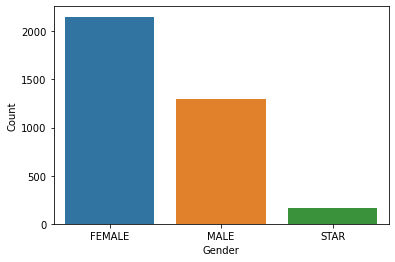

In [35]:
ax = sns.countplot(data=df_1, x= 'gender', order = df_1['gender'].value_counts().index)
ax.set(xlabel='Gender', ylabel='Count')

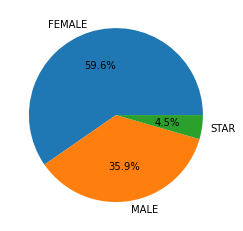

In [36]:
val_counts = df_1.gender.value_counts()/np.sum(df_1.gender.value_counts())
labels = val_counts.index.to_list()
plt.pie(val_counts, labels = labels,autopct='%1.1f%%')
plt.show()

### Discussion of results

As we can see, none of the numerical features (`num_events`, `num_questions`, `percentage_correct` and `num_reading`) comes from a normal distribution. The features `num_events`, `num_questions` and `num_reading` are right skewed while we could say that the feature `percentage_correct` is left skewed.

Another interesting result is that $51\%$ of the users of the educational platform are female (but we should not forget that we don't have information about the gender of $15\%$ of the users of Lernnavi). The graphs above show the count percentage without taking into account that $15\%$ of users that haven't provided the platform with their personal data.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [37]:
# Your code for computing the features and adding them to the df goes here

# Adding feature 1:
df_2 = df_1.merge(users[['user_id', 'class_level']], on='user_id')
df_2

,index,user_id,gender,num_events,num_questions,percentage_correct,num_reading,class_level
0,0,388047,MALE,738,81,44.09,2,Gymnasium - 2. Jahr
1,313,388363,NaN,1185,122,50.89,24,NaN
2,761,393224,FEMALE,201,54,69.71,1,Kurzzeitgymnasium - 3. Jahr
3,936,393232,FEMALE,157,38,63.49,6,Langzeitgymnasium - 5. Jahr
4,1062,393230,NaN,111,33,67.96,1,NaN
...,...,...,...,...,...,...,...,...
4227,1125818,404573,MALE,232,27,31.30,1,Gymnasium - 1. Jahr
4228,1125941,404589,MALE,71,9,53.23,4,Gymnasium - 1. Jahr
4229,1125972,404598,MALE,225,1,37.50,15,Gymnasium - 1. Jahr
4230,1125980,404599,NaN,169,1,30.00,38,NaN


In [38]:
# Adding feature 2:
test_data = events.groupby(['user_id', 'action']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == 'REVIEW_TASK']
test_data = test_data.rename(columns = {0: "num_reviewing"}, errors="raise")
test_data = test_data.drop(columns = ['action'])
test_data

,user_id,num_reviewing
11,387604,168
36,387605,313
62,387608,81
85,387615,25
110,387644,38
...,...,...
130155,404597,6
130169,404598,5
130183,404599,5
130197,404603,17


In [39]:
df_2 = df_2.merge(test_data, on='user_id')
df_2 = df_2[['user_id', 'gender', 'class_level', 'num_events', 'num_questions', 'percentage_correct', 'num_reading', 'num_reviewing']]
df_2

,user_id,gender,class_level,num_events,num_questions,percentage_correct,num_reading,num_reviewing
0,388047,MALE,Gymnasium - 2. Jahr,738,81,44.09,2,121
1,388363,NaN,NaN,1185,122,50.89,24,76
2,393224,FEMALE,Kurzzeitgymnasium - 3. Jahr,201,54,69.71,1,7
3,393232,FEMALE,Langzeitgymnasium - 5. Jahr,157,38,63.49,6,6
4,393230,NaN,NaN,111,33,67.96,1,2
...,...,...,...,...,...,...,...,...
4168,404573,MALE,Gymnasium - 1. Jahr,232,27,31.30,1,38
4169,404589,MALE,Gymnasium - 1. Jahr,71,9,53.23,4,10
4170,404598,MALE,Gymnasium - 1. Jahr,225,1,37.50,15,5
4171,404599,NaN,NaN,169,1,30.00,38,5


### Feature 1
The first feature I have added is just the class level of the students (`class_level` column in `users` data frame). By adding this new feature we can:

* Check whether students in higher levels participate in more events.
* Check whether students in higher levels perform more reading tasks in Lernnavi.
* Perform comparisons between the results (`percentage_correct`) obtain by students of different levels in the platform.
* Perform comparisons between the number of questions that students from different levels submit, etc.

### Feature 2
The second feature I have added is the total number of review events (action event = `REVIEW_TASK`). By adding this new feature we can:

* Check if an increase in the number of review tasks leads to an increase in the performance of students (`percentage_correct`).
* Check the following hyphotesis: the more events a user performs, the more review tasks the user performs.
* We can study if students from higher levels perform more reviewing tasks than students from lower levels.
* We can also check if the more reading events a user performs, the less review tasks the user performs.

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

In [40]:
# Your code for univariate analysis goes here
feature_list = [df_2['num_reviewing']]

data = {'Mean': np.mean(feature_list,1),
        'Median':np.median(feature_list,1),
        'Mode': (stats.mode(feature_list,axis=1)[0])[:,0],
        'Variance':np.var(feature_list,1),
        'Std':np.std(feature_list,1),
        'Minimum': np.min(feature_list,1),
        '25%': np.percentile(feature_list, 25, axis=1),
        '75%': np.percentile(feature_list, 75, axis=1),
        'Maximum': np.max(feature_list,1)}
desc_stats_df = pd.DataFrame(data, index =['num_reviewing'])

display(desc_stats_df)

,Mean,Median,Mode,Variance,Std,Minimum,25%,75%,Maximum
num_reviewing,86.83,46.0,20,15379.78,124.02,1,22.0,98.0,1231


p = 0
The null hypothesis can be rejected


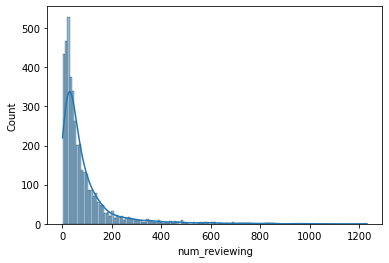

In [41]:
# right skewed
test_normality(df_2['num_reviewing'])
sns.histplot(data=df_2, x = 'num_reviewing', kde=True) 
plt.show()

In [42]:
class_level = df_2.class_level.value_counts(dropna=False)
pd.DataFrame({"Class Level": class_level.index, "Count": class_level.tolist(), "Count %": class_level.tolist()/np.sum(class_level.tolist()) })

,Class Level,Count,Count %
0,Gymnasium - 1. Jahr,901,2.16e-01
1,NaN,566,1.36e-01
2,Gymnasium - 2. Jahr,522,1.25e-01
3,Kurzzeitgymnasium - 1. Jahr,342,8.20e-02
4,Langzeitgymnasium - 3. Jahr,172,4.12e-02
5,Kurzzeitgymnasium - 2. Jahr,160,3.83e-02
6,FMS - 1. Jahr,154,3.69e-02
7,Gymnasium - 3. Jahr,131,3.14e-02
8,Langzeitgymnasium - 4. Jahr,125,3.00e-02
9,Gymnasium - 1. Jahr (GYM1),113,2.71e-02


[Text(0.5, 0, 'Class Level'), Text(0, 0.5, 'Count')]

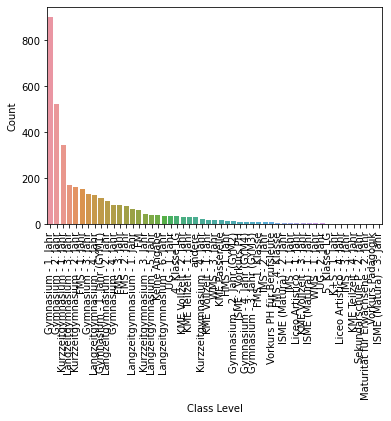

In [43]:
ax = sns.countplot(data=df_2, x= 'class_level', order = df_2['class_level'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Class Level', ylabel='Count')

### Discussion of results

As we can see, the numerical features `num_reviewing` doesn't come from a normal distribution. We can visually appreciate that the features `num_reviewing` is right skewed.

Another interesting result is that the levels with more users are `Gymnasium - 1. Jahr` ($901$ students) and `Gymnasium - 2. Jahr` ($522$ students), the first one with almost double the users of the second one. However, we should not forget that we don't have information about the class level of $566$ users of Lernnavi as they haven't provided the platform with their personal data.

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

H1: The number of questions submitted per user increases with the number of theory reading events that the user performs.

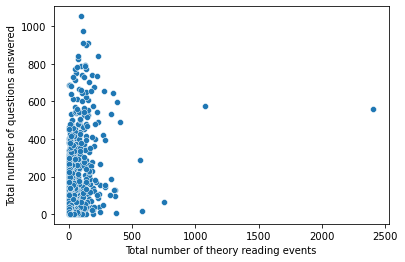

In [44]:
# Your code for multivariate analysis goes here
# Visualization of the pair
sns.scatterplot(data= df_1, y = 'num_questions', x = 'num_reading')
plt.xlabel("Total number of theory reading events")
plt.ylabel("Total number of questions answered")
plt.show()

In [45]:
# Correlation between variables (pairwise comparisonn)
r, p = stats.pearsonr(df_1['num_questions'], df_1['num_reading'])
print(r, p)

0.35129965576541144 3.592907298324113e-123


In [46]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import chi2_contingency

x = np.array(df_1['num_reading']).reshape(-1,1)
y = np.array(df_1['num_questions']).ravel()

mi = mutual_info_regression(x, y, n_neighbors=1)
print(mi)

[0.03538381]


My hypothesis is clearly rejected since it seems that there are users that have performed few reading theory actions but that have submitted a lot of questions. The low correlation coefficient reveals that there isn't a linear relationship between the two numerical features. Additionally, the low mutual information coefficient between these two variables shows that there is no relationship between the variables at all.

H1 bis: The number of questions submitted per user increases with the number of theory reading events that the user performs and there is no difference between males and females.

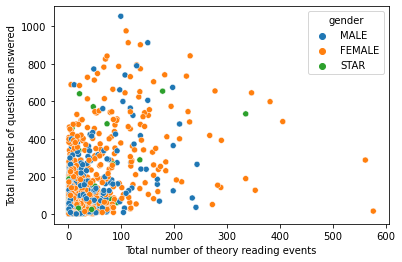

In [47]:
sns.scatterplot(data= df_1, y = 'num_questions', x = 'num_reading', hue='gender')
plt.xlabel("Total number of theory reading events")
plt.ylabel("Total number of questions answered")
plt.show()

There is no difference between the behaviour of females and males.

H2: The number of questions submitted per user increases with the number of events that the user performs.

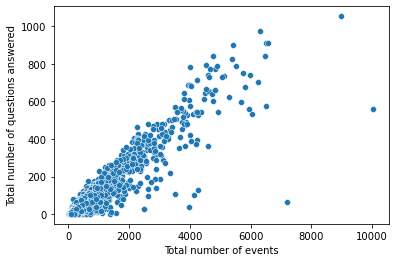

In [48]:
sns.scatterplot(data= df_1, y = 'num_questions', x = 'num_events')
plt.xlabel("Total number of events")
plt.ylabel("Total number of questions answered")
plt.show()

In [49]:
# Correlation between variables (pairwise comparisonn)
r, p = stats.pearsonr(df_1['num_questions'], df_1['num_events'])
print(r, p)

0.9310419603159714 0.0


In [50]:
# Mutual Information
x = np.array(df_1['num_events']).reshape(-1,1)
y = np.array(df_1['num_questions']).ravel()

mi = mutual_info_regression(x, y, n_neighbors=1)
print(mi)

[0.46900377]


The results confirm my hypothesis since it seems that there exists a linear relationship between the total number of events that a particular user performs and the total number of questions answered by that particular user. The high correlation coefficient reveals that there exists a linear relationship between the two numerical features. Additionally, the mutual information coefficient between these two variables shows that there exists a relationship between these two variables.

H2 bis: The number of questions submitted per user increases with the number of events that the user performs and there is no difference between males and females.

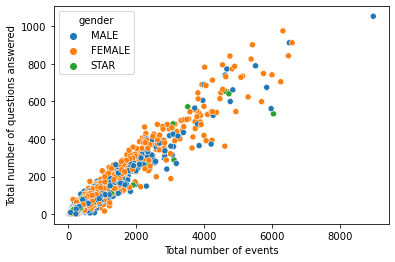

In [51]:
sns.scatterplot(data= df_1, y = 'num_questions', x = 'num_events', hue='gender')
plt.xlabel("Total number of events")
plt.ylabel("Total number of questions answered")
plt.show()

There is no difference between the behaviour of females and males.

H3: The number of reading theory events per user increases with the number of events that the user performs.

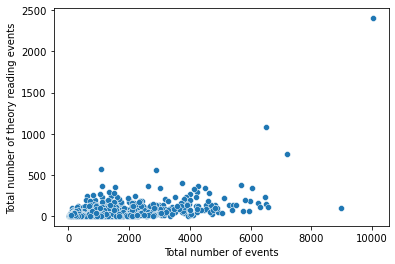

In [52]:
sns.scatterplot(data= df_1, y = 'num_reading', x = 'num_events')
plt.xlabel("Total number of events")
plt.ylabel("Total number of theory reading events")
plt.show()

In [53]:
# Correlation between variables (pairwise comparisonn)
r, p = stats.pearsonr(df_1['num_reading'], df_1['num_events'])
print(r, p)

0.5391895934942517 6.748413e-318


In [54]:
# Mutual Information
x = np.array(df_1['num_events']).reshape(-1,1)
y = np.array(df_1['num_reading']).ravel()

mi = mutual_info_regression(x, y, n_neighbors=1)
print(mi)

[0.11511904]


My hypothesis is clearly rejected since it seems that there are users that haven't participate in may events but they have perfomed as many reading theory actions as users that have participated in a lot of events. The low correlation coefficients reveals that there isn't a linear relationship between the two numerical features. Additionally, the low mutual information coefficient between these two variables shows that there is no relationship between the variables at all.

H3 bis: The number of reading theory events per user increases with the number of events that the user performs and there is no difference between males and females.

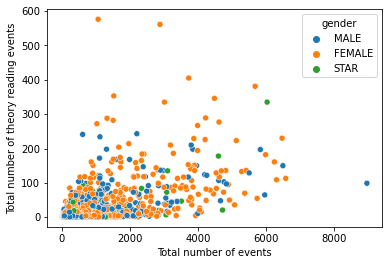

In [55]:
sns.scatterplot(data= df_1, y = 'num_reading', x = 'num_events', hue='gender')
plt.xlabel("Total number of events")
plt.ylabel("Total number of theory reading events")
plt.show()

There is no difference between the behaviour of females and males.

### Notes:
- I choose to study the pair `num_questions`-`num_reading` because I wanted to check whether the number of questions a user submits is proportional to the number of readings performed by the user. In other words, I wanted to check whether the users of the platform are in the habit of reading the theory of the subject before asking the questions.
- In addition, I choose to study the pair `num_questions`-`num_events` because I wanted to check wheter the number of questions a user submits increases with the number of events performed by the user. I thought it was reasonable to believe that there must be a linear relationship between the two variables.
- Finally, I have choosed an additional third pair for studying the relationship between the variables `num_reading`-`num_events` just to check if the users are in the habit of reading the theory of the subject before participating in events of the platform. This las pair is redundant since I have already study the pairs `num_questions`-`num_reading` and `num_questions`-`num_events`.
- I have also added additional plots per pair to check whether the behaviour is different between females and males. The answer is no: females and males seem to have a similar behaviour in the educational platform.
- Also, I have to remark that I haven't chosen to study the percentage of correct answers (`percentage_correct`) since I do not consider it a good measure of the performance of a particular user because it is a relative measure. For example, we have two users: the first one has submitted correct 99 out of 100 submitted answers and the second one has only submitted one answer and it was correct. Only studying the variable `percentage_correct` it seems that the second student has a better performance than the first one.

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

First of all, I will begin creating my new data frame (`new_data`) by picking the `events` dataframe and adding to it the feature `week_of_year`, which is going to be obtained from the feature `timestamp` of the data frame `events`.

In [56]:
# Your code for building the dataframe goes here
new_data = events
new_data = new_data.reset_index().drop(columns = ['index'])
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'], unit = 'ms')
new_data['week_of_year'] = new_data['timestamp'].dt.isocalendar().week
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year
0,69,392476,2021-05-21 08:05:25.174,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,20
1,70,392476,2021-05-21 08:06:05.975,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,20
2,72,392476,2021-05-21 08:07:21.478,TASK,VIEW_QUESTION,VIEW,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,20
3,73,392476,2021-05-21 08:07:26.771,TASK,GO_TO_THEORY,CLICK,46a3af7d-4451-4e1e-ada8-edf9a6d0c3b7,33768.0,NaN,20
4,223,393213,2021-05-21 09:27:25.107,TASK,VIEW_QUESTION,VIEW,54aaee3c-cad7-45da-a436-61fa51cedea3,34343.0,NaN,20
...,...,...,...,...,...,...,...,...,...,...
3259194,3518462,404560,2022-02-22 08:52:13.345,TASK,SUBMIT_ANSWER,CLICK,9edfed2d-ebe8-4b0e-873c-9ba13e6541b3,112259.0,NaN,8
3259195,3518463,404560,2022-02-22 08:52:14.803,TASK,NEXT,CLICK,9edfed2d-ebe8-4b0e-873c-9ba13e6541b3,112259.0,NaN,8
3259196,3518464,404560,2022-02-22 08:52:15.451,SESSION,REVIEW_TASK,VIEW,133248bc-5771-4240-94c2-77b23b7c2d97,112259.0,NaN,8
3259197,3518465,404552,2022-02-22 08:52:16.842,USER_SESSION,WINDOW_VISIBLE_TRUE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/session/...",8


Then, I will proceed to introduce the `num_questions` feature in the data frame `new_data`:

In [57]:
test_data = new_data
test_data = test_data.groupby(['user_id', 'week_of_year', 'action']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == 'SUBMIT_ANSWER']
test_data = test_data.rename(columns = {0: "num_questions"}, errors="raise")
test_data = test_data.drop(columns = ['action'])
test_data

,user_id,week_of_year,num_questions
2,387604,1,1
9,387604,2,2
19,387604,3,1
79,387604,35,1
110,387604,38,4
...,...,...,...
283127,404597,8,1
283141,404598,8,1
283155,404599,8,1
283169,404603,8,13


In [58]:
new_data = new_data.merge(test_data, on=['user_id','week_of_year'])
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26
...,...,...,...,...,...,...,...,...,...,...,...
3080427,3516991,394765,2022-02-22 08:15:02.037,SESSION,REVIEW_TASK,VIEW,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1
3080428,3517002,394765,2022-02-22 08:15:26.144,SESSION,SKIP,CLICK,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1
3080429,3517003,394765,2022-02-22 08:15:26.518,SESSION,REVIEW_TASK,VIEW,1ece2c7b-c8f7-4bf5-b062-dc9b17b8cbcb,110100.0,NaN,8,1
3080430,3517004,394765,2022-02-22 08:15:29.638,USER_SESSION,WINDOW_CLOSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/session/...",8,1


Now, I will introduce the numerical variable `num_events` in the data frame:

In [59]:
test_data = new_data
test_data = test_data.groupby(['user_id', 'week_of_year']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0: "num_events"}, errors="raise")
test_data

,user_id,week_of_year,num_events
0,387604,1,6
1,387604,2,17
2,387604,3,35
3,387604,35,405
4,387604,38,131
...,...,...,...
18503,404597,8,95
18504,404598,8,225
18505,404599,8,169
18506,404603,8,112


In [60]:
new_data = new_data.merge(test_data, on=['user_id','week_of_year'])
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92
...,...,...,...,...,...,...,...,...,...,...,...,...
3080427,3516991,394765,2022-02-22 08:15:02.037,SESSION,REVIEW_TASK,VIEW,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1,13
3080428,3517002,394765,2022-02-22 08:15:26.144,SESSION,SKIP,CLICK,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1,13
3080429,3517003,394765,2022-02-22 08:15:26.518,SESSION,REVIEW_TASK,VIEW,1ece2c7b-c8f7-4bf5-b062-dc9b17b8cbcb,110100.0,NaN,8,1,13
3080430,3517004,394765,2022-02-22 08:15:29.638,USER_SESSION,WINDOW_CLOSE,VIEW,NaN,NaN,"{""location"": ""https://app.lernnavi.ch/session/...",8,1,13


Now, I am computing the number of correct answers/total number of answers for every user (`percentage_correct`) and adding that information to my dataframe (`new_data`).

In [61]:
new_data = new_data.merge(new_transactions_data, on='transaction_token')
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events,evaluation
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493589,3516831,394775,2022-02-22 08:04:11.185,TASK,SUBMIT_ANSWER,CLICK,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5
1493590,3516832,394775,2022-02-22 08:04:11.886,SESSION,REVIEW_TASK,VIEW,2b3c11b4-7fd8-4c1f-ae19-92f5d1a0b7b7,112228.0,NaN,8,1,14,NaN
1493591,3516991,394765,2022-02-22 08:15:02.037,SESSION,REVIEW_TASK,VIEW,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1,13,NaN
1493592,3517002,394765,2022-02-22 08:15:26.144,SESSION,SKIP,CLICK,413fd175-714e-47ec-870b-43070c7b9037,110100.0,NaN,8,1,13,NaN


In [62]:
test_data = new_data[['user_id', 'week_of_year', 'evaluation']]
test_data = test_data.groupby(['user_id', 'week_of_year', 'evaluation']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0: 'counts'})
test_data['total_points'] = test_data['evaluation'] * test_data['counts']
test_data = test_data[['user_id', 'week_of_year', 'total_points']]
test_data = test_data.groupby(['user_id', 'week_of_year']).aggregate(lambda x: np.sum(np.array(list(x)))).reset_index()
test_data

,user_id,week_of_year,total_points
0,387604,1,0.0
1,387604,2,4.0
2,387604,3,1.0
3,387604,35,0.0
4,387604,38,1.0
...,...,...,...
18501,404597,8,1.0
18502,404598,8,3.0
18503,404599,8,3.0
18504,404603,8,28.5


In [63]:
new_data = new_data.merge(test_data, on=['user_id', 'week_of_year'])
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events,evaluation,total_points
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493571,3516473,389181,2022-02-22 07:13:53.264,TASK,VIEW_QUESTION,VIEW,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0
1493572,3516474,389181,2022-02-22 07:13:54.057,SESSION,CLOSE,CLICK,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0
1493573,3516778,394775,2022-02-22 07:59:08.808,SESSION,REVIEW_TASK,VIEW,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0
1493574,3516831,394775,2022-02-22 08:04:11.185,TASK,SUBMIT_ANSWER,CLICK,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0


In [64]:
test_data = new_data[['user_id', 'week_of_year', 'evaluation']]
test_data = test_data.groupby(['user_id', 'week_of_year']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0: 'counts'})
test_data

,user_id,week_of_year,counts
0,387604,1,2
1,387604,2,4
2,387604,3,7
3,387604,35,29
4,387604,38,13
...,...,...,...
18501,404597,8,9
18502,404598,8,8
18503,404599,8,10
18504,404603,8,62


In [65]:
new_data = new_data.merge(test_data, on=['user_id', 'week_of_year'])
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events,evaluation,total_points,counts
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5,89
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5,89
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493571,3516473,389181,2022-02-22 07:13:53.264,TASK,VIEW_QUESTION,VIEW,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0,44
1493572,3516474,389181,2022-02-22 07:13:54.057,SESSION,CLOSE,CLICK,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0,44
1493573,3516778,394775,2022-02-22 07:59:08.808,SESSION,REVIEW_TASK,VIEW,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0,3
1493574,3516831,394775,2022-02-22 08:04:11.185,TASK,SUBMIT_ANSWER,CLICK,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0,3


In [66]:
new_data['percentage_correct'] = new_data['total_points']/new_data['counts'] * 100
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events,evaluation,total_points,counts,percentage_correct
0,225,388032,2021-05-21 10:15:30.730,TASK,VIEW_QUESTION,VIEW,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5,89,25.28
1,254,388032,2021-05-21 10:25:03.295,SESSION,SKIP,CLICK,678f68ca-006b-4452-a2cf-210f1c75e0b5,30695.0,NaN,20,26,92,NaN,22.5,89,25.28
2,255,388032,2021-05-21 10:25:03.707,TASK,VIEW_QUESTION,VIEW,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89,25.28
3,256,388032,2021-05-21 10:25:51.343,TASK,SUBMIT_ANSWER,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89,25.28
4,257,388032,2021-05-21 10:25:53.872,TASK,NEXT,CLICK,f1b1234a-b454-4bf0-93f8-e829253246c4,30695.0,NaN,20,26,92,0.0,22.5,89,25.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493571,3516473,389181,2022-02-22 07:13:53.264,TASK,VIEW_QUESTION,VIEW,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0,44,65.91
1493572,3516474,389181,2022-02-22 07:13:54.057,SESSION,CLOSE,CLICK,647a537d-a073-4419-a782-3b52ff2d896f,112223.0,NaN,8,10,71,NaN,29.0,44,65.91
1493573,3516778,394775,2022-02-22 07:59:08.808,SESSION,REVIEW_TASK,VIEW,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0,3,33.33
1493574,3516831,394775,2022-02-22 08:04:11.185,TASK,SUBMIT_ANSWER,CLICK,b4b100cd-0023-4663-b739-df1c56327a1b,112228.0,NaN,8,1,14,0.5,1.0,3,33.33


I will proceed in a similar way to the creation of the `num_questions` column to introduce the `num_reading` feature in the data frame `new_data`:

In [67]:
test_data = new_data
test_data = test_data.groupby(['user_id', 'week_of_year', 'action']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == 'GO_TO_THEORY']
test_data = test_data.rename(columns = {0: "num_reading"}, errors="raise")
test_data = test_data.drop(columns = ['action'])
test_data

,user_id,week_of_year,num_reading
36,387604,46,5
81,387605,27,1
87,387605,28,1
181,387615,35,1
209,387650,4,1
...,...,...,...
101523,404553,8,2
101530,404555,8,1
101552,404560,8,1
101558,404561,8,1


In [68]:
new_data = new_data.merge(test_data, on=['user_id','week_of_year'])
new_data

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data,week_of_year,num_questions,num_events,evaluation,total_points,counts,percentage_correct,num_reading
0,450,393224,2021-05-21 11:16:30.008,TASK,VIEW_QUESTION,VIEW,ed60c0b6-b568-4ac6-b26d-b017a3f3360d,34362.0,NaN,20,24,89,0.5,58.5,83,70.48,1
1,471,393224,2021-05-21 11:17:46.968,TASK,SUBMIT_ANSWER,CLICK,ed60c0b6-b568-4ac6-b26d-b017a3f3360d,34362.0,NaN,20,24,89,0.5,58.5,83,70.48,1
2,482,393224,2021-05-21 11:18:33.960,TASK,VIEW_QUESTION,VIEW,d949586c-f360-4ed3-bfe2-63904a6d3bfe,34362.0,NaN,20,24,89,1.0,58.5,83,70.48,1
3,488,393224,2021-05-21 11:19:04.064,TASK,SUBMIT_ANSWER,CLICK,d949586c-f360-4ed3-bfe2-63904a6d3bfe,34362.0,NaN,20,24,89,1.0,58.5,83,70.48,1
4,489,393224,2021-05-21 11:19:06.013,TASK,NEXT,CLICK,d949586c-f360-4ed3-bfe2-63904a6d3bfe,34362.0,NaN,20,24,89,1.0,58.5,83,70.48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344479,3516355,402158,2022-02-22 07:03:42.342,SESSION,REVIEW_TASK,VIEW,db0555f4-736f-40f8-9e5e-48542b3188da,112219.0,NaN,8,2,27,1.0,3.0,9,33.33,1
344480,3516397,402158,2022-02-22 07:06:04.738,TASK,SUBMIT_ANSWER,CLICK,db0555f4-736f-40f8-9e5e-48542b3188da,112219.0,NaN,8,2,27,1.0,3.0,9,33.33,1
344481,3516399,402158,2022-02-22 07:06:06.659,TASK,NEXT,CLICK,db0555f4-736f-40f8-9e5e-48542b3188da,112219.0,NaN,8,2,27,1.0,3.0,9,33.33,1
344482,3516400,402158,2022-02-22 07:06:06.941,SESSION,REVIEW_TASK,VIEW,d581179b-30de-49f9-9640-aacb1ec20d2a,112219.0,NaN,8,2,27,NaN,3.0,9,33.33,1


Finally, I will reorganise the features inside the data frame and I will add the `week` column to the dataframe, which is going to be the difference between the week of the year we are (`week_of_year`) and the week the user started (which is also going to be computed below and I will refer to it as `week_min`). I will also going to limit the number of weeks I am studying per user to 13.

In [69]:
df_3 = new_data[['user_id', 'week_of_year', 'num_events', 'num_questions', 'percentage_correct', 'num_reading']]
df_3 = df_3.drop_duplicates()
df_3

,user_id,week_of_year,num_events,num_questions,percentage_correct,num_reading
0,393224,20,89,24,70.48,1
83,393232,20,65,20,74.59,1
144,393230,20,65,20,85.25,1
205,389839,24,55,8,51.32,1
243,392932,21,44,7,46.51,1
...,...,...,...,...,...,...
344294,404561,8,93,3,100.00,1
344307,394686,8,200,29,56.90,2
344423,387650,8,88,1,8.33,1
344435,394331,8,75,5,7.50,1


In [70]:
test_data = df_3[['user_id', 'week_of_year']]
test_data = test_data.groupby(['user_id']).aggregate(lambda x: np.min(np.array(list(x)))).reset_index()
test_data = test_data.rename(columns = {"week_of_year": "week_min"}, errors="raise")
test_data

,user_id,week_min
0,387604,46
1,387605,27
2,387615,35
3,387650,4
4,387666,46
...,...,...
2002,404553,8
2003,404555,8
2004,404560,8
2005,404561,8


In [71]:
df_4 = df_3.merge(test_data, on='user_id')
df_4['week'] = df_4['week_of_year'] - df_4['week_min']
df_4 = df_4.drop(columns = ['week_of_year', 'week_min'])
df_4 = df_4[['user_id', 'week', 'num_events', 'num_questions', 'percentage_correct', 'num_reading']]
total_weeks = 13
df_4 = df_4[df_4['week'].between(0,total_weeks, inclusive = 'left')]
df_4 = df_4.drop_duplicates().reset_index().drop(columns = ['index'])
df_4

,user_id,week,num_events,num_questions,percentage_correct,num_reading
0,393224,0,89,24,70.48,1
1,393232,0,65,20,74.59,1
2,393232,1,48,13,40.91,5
3,393230,0,65,20,85.25,1
4,389839,0,55,8,51.32,1
...,...,...,...,...,...,...
2415,404563,0,88,3,92.31,1
2416,404560,0,88,8,33.33,1
2417,404561,0,93,3,100.00,1
2418,394331,0,75,5,7.50,1


In [72]:
df_4.iloc[500]

user_id               394689.0
week                       7.0
num_events               317.0
num_questions             19.0
percentage_correct       34.03
num_reading                1.0
Name: 500, dtype: Float64

#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

H1: The students’ number of events is constant throughout the semester.

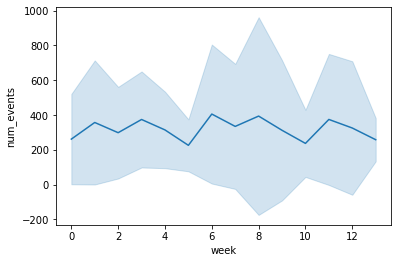

In [73]:
ax = sns.lineplot(data=df_4.astype('float64'), x="week", y="num_events", ci='sd')
plt.show()

The results obtained confirm my hypothesis: the number of events seems to be constant throughout the semester. We can appreciate in the graph that there isn't a significant variation of the number of events performed by the users of the platform throughout the semester.

H2: The students’ number of submitted questions decreases throughout the semester.

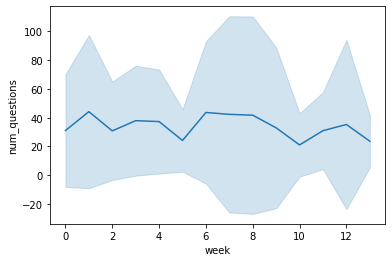

In [74]:
ax = sns.lineplot(data=df_4.astype('float64'), x="week", y="num_questions", ci='sd')
plt.show()

The results obtained do not confirm my hypothesis. It seems that the students' number of submitted questions is constant throughout the semester. In other words, there is no a huge variation in the number of questions submitted by the students at the different weeks of the semester.

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses? 



In [75]:
# Your creative visualization here
df_5 = df_4.astype('float64').merge(users[['user_id','gender']], on='user_id')
df_5

,user_id,week,num_events,num_questions,percentage_correct,num_reading,gender
0,393224.0,0.0,89.0,24.0,70.48,1.0,FEMALE
1,393232.0,0.0,65.0,20.0,74.59,1.0,FEMALE
2,393232.0,1.0,48.0,13.0,40.91,5.0,FEMALE
3,393230.0,0.0,65.0,20.0,85.25,1.0,NaN
4,389839.0,0.0,55.0,8.0,51.32,1.0,NaN
...,...,...,...,...,...,...,...
2415,404563.0,0.0,88.0,3.0,92.31,1.0,FEMALE
2416,404560.0,0.0,88.0,8.0,33.33,1.0,FEMALE
2417,404561.0,0.0,93.0,3.0,100.00,1.0,FEMALE
2418,394331.0,0.0,75.0,5.0,7.50,1.0,FEMALE


H3: The students’ percentage of correct questions increases throughout the semester and there is no difference between males and females.

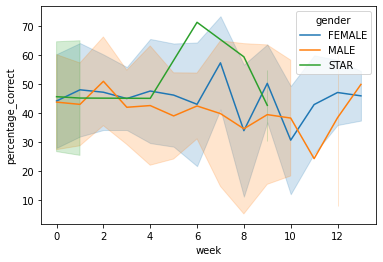

In [76]:
ax = sns.lineplot(data=df_5, x="week", y="percentage_correct", ci='sd', hue='gender')
plt.show()

I observed that the students' percentage of correct questions does not seem to increase throughout the semester. In fact, it seems that the percentage of correct questions remains constant throughout the semester. However, it seems that there is no difference between females and males. As a consequence of the results obtained, my hypothesis is only partially confirmed.

H4: The students’ number of theory reading events decreases throughout the semester but it suddendly increases in the last week and that behaviour doesn't differ between males and females.

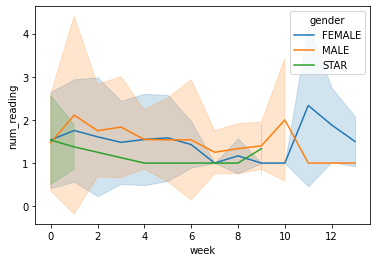

In [77]:
ax = sns.lineplot(data=df_5, x="week", y="num_reading", ci='sd', hue='gender')
plt.show()

I observed that the students' number of theory reading events performed does not seem to decrease too much throughout the semester. In fact, it seems that the number of theory reading events performed by the students of the platform remains constant throughout the semester. I don't observed neither the suddendly increased in the number of theory reading events performed by the users of the platform in the last week. I was expecting that the users will perform more theory reading events in the last week because of the proximity of the exam but the results show that it isn't the case. However, it seems that there is no difference between females and males. As a consequence of the results obtained, my hypothesis is only partially confirmed.